In [4]:
from pathlib import Path
import requests
import pickle
import gzip
import matplotlib.pyplot as plt
import numpy as np 
import torch
import math

DATA_PATH=Path("data")
PATH=DATA_PATH/"mnist"
PATH.mkdir(parents=True,exist_ok=True)
URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH/FILENAME).as_posix(),'rb') as f:
    ((x_train,y_train),(x_valid,y_valid),_)=pickle.load(f,encoding="latin-1")
   

GPU results at batchsize 64 runtime is 7.835002899169922
GPU results at batchsize 128 runtime is 4.226001501083374
GPU results at batchsize 256 runtime is 2.752002000808716
GPU results at batchsize 512 runtime is 1.981997013092041
GPU results at batchsize 1024 runtime is 1.602001667022705


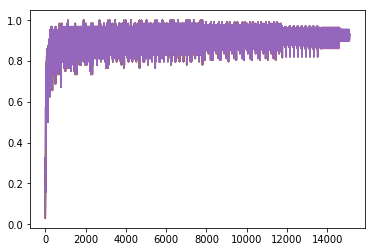

In [20]:
import torch
from torch.nn import functional as F
from torch import nn, optim
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

# refactor using nn.Linear
class Mnist_Logistics(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 100)
        self.lin2 = nn.Linear(100, 10)
    
    def forward(self, xb):
        out = self.lin(xb)
        return self.lin2(out)

def accuracy(output, y_actual):
    preds = torch.argmax(output, dim=1)
    return (preds == y_actual).float().mean()

x_train = x_train.cuda()
y_train  = y_train.cuda()

bz=[64,128,256,512,1024]
#bs = 64
lr = 0.02
epochs = 10
model = Mnist_Logistics().cuda()
opt = optim.SGD(model.parameters(), lr=lr)
loss_func = F.cross_entropy
accuracies = []
import time
for bs in bz:
    start=time.time()
    for e in range(epochs):
        for i in range(x_train.shape[0] // bs):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i: end_i]
            yb = y_train[start_i: end_i]
            y_pred = model(xb)
            loss = loss_func(y_pred, yb) 

            acc = accuracy(y_pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            accuracies.append(acc)

    plt.plot(accuracies)
    print(f"GPU at batchsize {bs} runtime is {time.time()-start}")